In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
np.random.seed(0)

import shap
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
optuna.logging.disable_default_handler()



In [2]:
def encode_and_bind(original_dataframe, feature_to_encode):
    new_df = pd.get_dummies(original_dataframe, columns= feature_to_encode,drop_first=True,dummy_na = True)
    #new_df.drop('id', inplace=True, axis=1)
    return new_df


def fill_all_nan_to_minus_one(dataframe):   
    return dataframe.fillna(-1)



In [3]:
df = pd.read_csv("Data/patient_features_early_stage.csv",sep=",")
Y = df['relapse?'].values
df.drop(['id','relapse?'], inplace=True, axis=1)
print ("Total number of relapsed patient in the data:",np.count_nonzero(Y))
print ("Total number of survived patient in the data:",len(Y)-np.count_nonzero(Y))
print ("Total number of patient:",len(Y))


Total number of relapsed patient in the data: 491
Total number of survived patient in the data: 857
Total number of patient: 1348


In [4]:
aneuploidy = np.loadtxt("JBI_Predicted_Aneuploidy_svr.txt",dtype = np.float32)
wnt = pd.read_csv("JBI_Predicted_WNT.txt",sep="," , usecols=[1]).values
vegf = pd.read_csv("JBI_Predicted_VEGF.txt",sep="," , usecols=[1]).values
trail = pd.read_csv("JBI_Predicted_Trail.txt",sep="," , usecols=[1]).values
egfr = pd.read_csv("JBI_Predicted_EGFR.txt",sep="," , usecols=[1]).values


# aneuploidy =np.loadtxt("JBI_Predicted_Aneuploidy_knn.txt",dtype = np.float32)
# wnt = pd.read_csv("JBI_Predicted_KNN_WNT.txt",sep="," , usecols=[1]).values
# vegf = pd.read_csv("JBI_Predicted_KNN_VEGF.txt",sep="," , usecols=[1]).values
# trail = pd.read_csv("JBI_Predicted_KNN_Trail.txt",sep="," , usecols=[1]).values
# egfr = pd.read_csv("JBI_Predicted_EGFR.txt",sep="," , usecols=[1]).values

In [5]:
#sorted(df.columns)

In [6]:
all_features = list(df.columns)
general_features = ["age",'family_lung_cancer','family_other_cancer','gender','lived_with_smokers_20_years',
                    'lives_with_smokers','nb_cig_packs_year','nb_cigs_day','previous_cancer_type','race','smoker']
surgery_features = [surg for surg in df.columns if surg.startswith('surgery')==True]
radio_therapy_features = [radio for radio in df.columns if radio.startswith('radio')==True]
chemo_therapy_features = [chemo for chemo in df.columns if chemo.startswith('chemo')==True]
treatment_features = surgery_features + radio_therapy_features + chemo_therapy_features
diagnosis_features = list(set(all_features) - set(general_features + treatment_features))

#all_features
#relapse prediction with first sugery and first chemotherapy feature#
#df = df[general_features + diagnosis_features + treatment_features]
#relapse prediction with diagnosis feature#
#df = df[general_features]
#df = df[diagnosis_features]
#df = df[general_features + diagnosis_features]
#relapse prediction with surgery feature#
#df = df[general_features + diagnosis_features + surgery_features]
#relapse prediction with radiotherapy feature#
#df = df[general_features + diagnosis_features + surgery_features]
#df = df[chemo_therapy_features]
#relapse prediction with first sugery and first chemotherapy feature#
#df = df[general_features + diagnosis_features + radio_therapy_features]
#df = df[general_features + diagnosis_features + radio_therapy_features + chemo_therapy_features + surgery_features]
#df = df.drop(df.columns.values, axis=1)
#df = df[treatment_features]
df = df[general_features + diagnosis_features + treatment_features]
# df = df.drop(columns=list(df.columns))
df["aneuploidy_imputed"]= aneuploidy
df["wnt_imputed"]= wnt
df["vegf_imputed"]= vegf
df["trail_imputed"]= trail
# df["egfr_imputed"] =egfr

cat_columns = list(df.select_dtypes(['object']).columns)
bool_columns = list(df.select_dtypes(['bool']).columns)
feature_to_encode = cat_columns + bool_columns

new_df = encode_and_bind(df, feature_to_encode)
new_df = fill_all_nan_to_minus_one(new_df)
X = new_df.values

In [7]:
df.head()

,age,family_lung_cancer,family_other_cancer,gender,lived_with_smokers_20_years,lives_with_smokers,nb_cig_packs_year,nb_cigs_day,previous_cancer_type,race,...,radiotherapy@t1_area,radiotherapy@t1_dose,radiotherapy@t1_fractioning,chemotherapy@t1_type,chemotherapy@t1_start_time,chemotherapy@t1_regimen,aneuploidy_imputed,wnt_imputed,vegf_imputed,trail_imputed
0,68.0,0.0,1.0,Male,False,False,NaN,NaN,NaN,Caucasian,...,NaN,NaN,NaN,Adjuvant chemotherapy,3.0,Combination,15.245860,-3.229589,17.699433,-4.631857
1,63.0,0.0,0.0,Male,False,False,86.0,40.0,NaN,Caucasian,...,NaN,NaN,NaN,QT intravenous,64.0,Combination,15.855964,-1.211800,-16.888589,5.891893
2,66.0,0.0,0.0,Female,True,False,60.0,40.0,Uterus/Cervical,Caucasian,...,NaN,NaN,NaN,QT intravenous,28.0,Combination,15.481607,-0.540465,-6.302582,7.216834
3,81.0,0.0,0.0,Male,True,False,80.0,30.0,NaN,Caucasian,...,NaN,NaN,NaN,NaN,NaN,NaN,13.642687,10.425755,-46.861891,-6.217465
4,63.0,1.0,1.0,Male,True,False,30.0,20.0,Prostate,Caucasian,...,NaN,NaN,NaN,QT intravenous,3.0,Monotherapy,15.855964,-1.211800,-16.888589,5.891893


In [8]:
X.shape

(1348, 219)

Permutation explainer: 1349it [05:14,  4.20it/s]                                                                                                                                                            


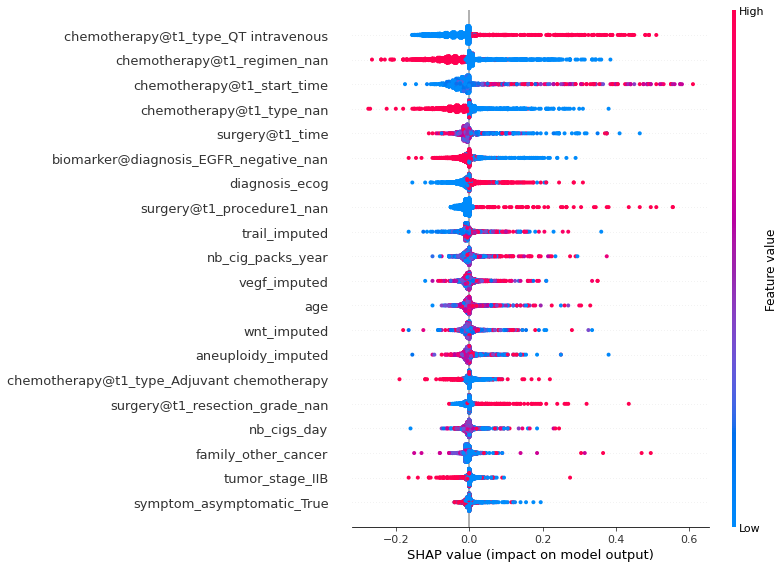

In [9]:
import matplotlib.pyplot as plt
# from sklearn.ensemble import GradientBoostingClassifier

# model = GradientBoostingClassifier()
# model = RandomForestClassifier(max_depth=6, random_state=7, n_estimators=10)
model = RandomForestClassifier()
# #model = LogisticRegression()
model.fit(X, Y)
# explainer = shap.Explainer(model.predict, X_test)

explainer = shap.Explainer(model.predict, X)
# explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

# f = plt.figure()
shap.summary_plot(shap_values, X, feature_names = new_df.columns.values)
# f.savefig("summary_plot1.eps", bbox_inches='tight')
# f.savefig("summary_plot1.png", bbox_inches='tight')

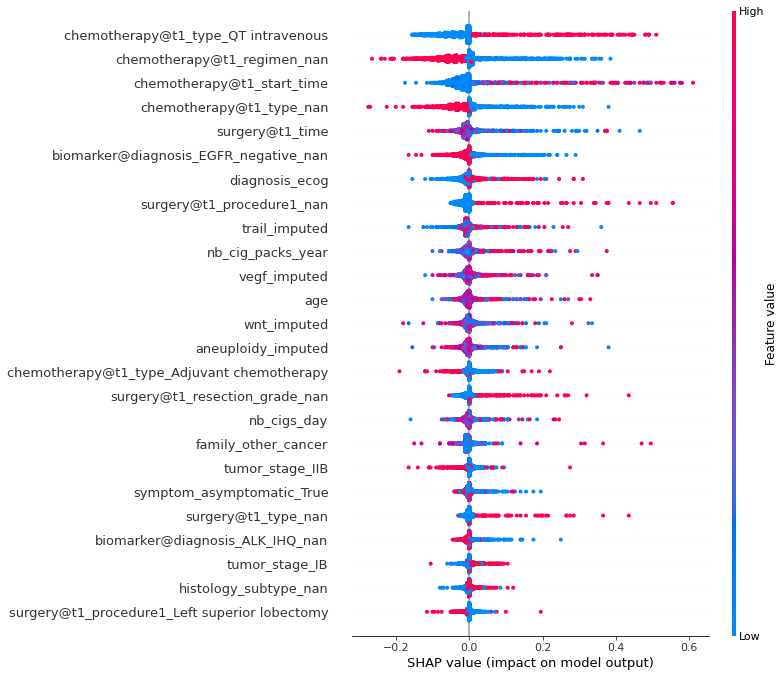

In [10]:
shap.summary_plot(shap_values, X, feature_names = new_df.columns.values,max_display=25)

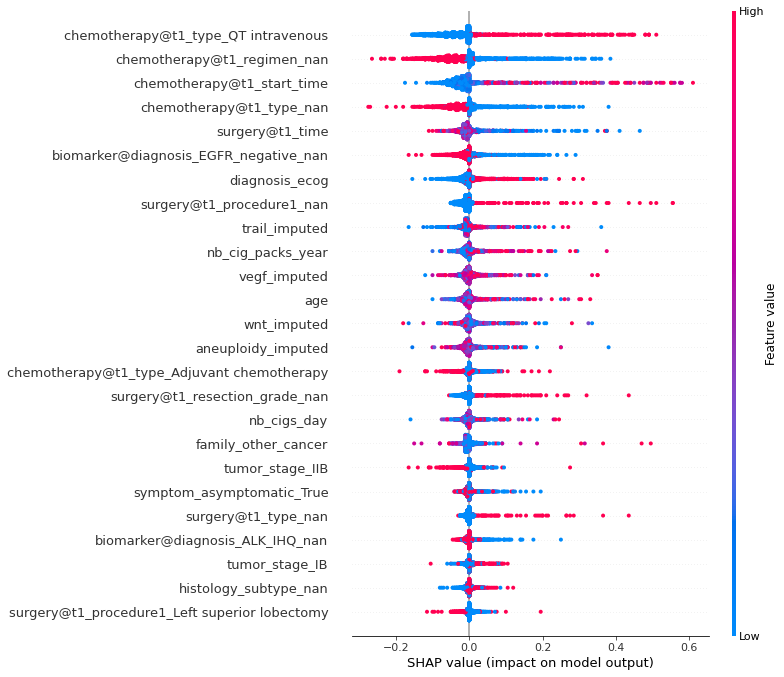

In [11]:
f = plt.figure()
shap.summary_plot(shap_values, X, feature_names = new_df.columns.values,max_display=25)
f.savefig("summary_plot_rf.pdf", bbox_inches='tight')

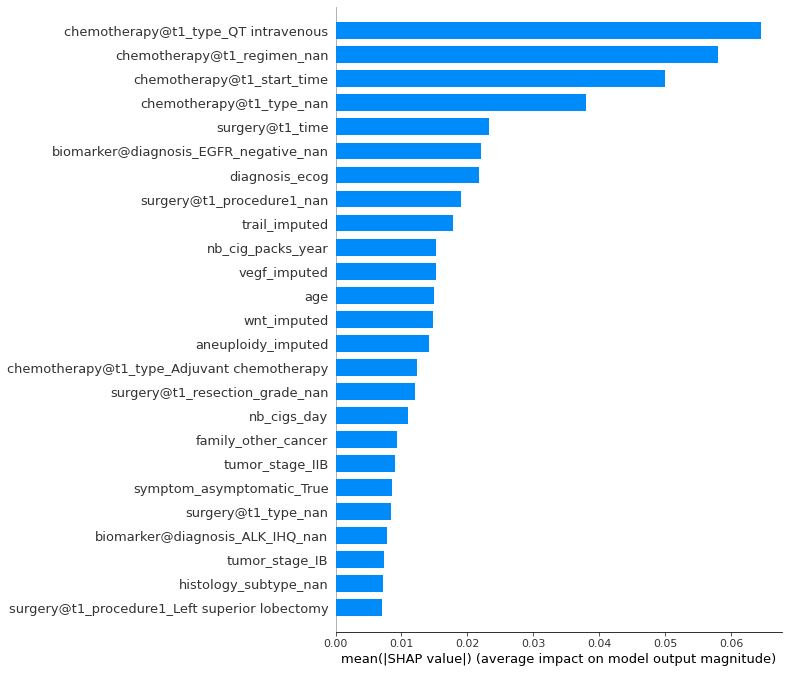

In [12]:
shap.summary_plot(shap_values, features=X, feature_names=new_df.columns.values, plot_type='bar',max_display = 25)

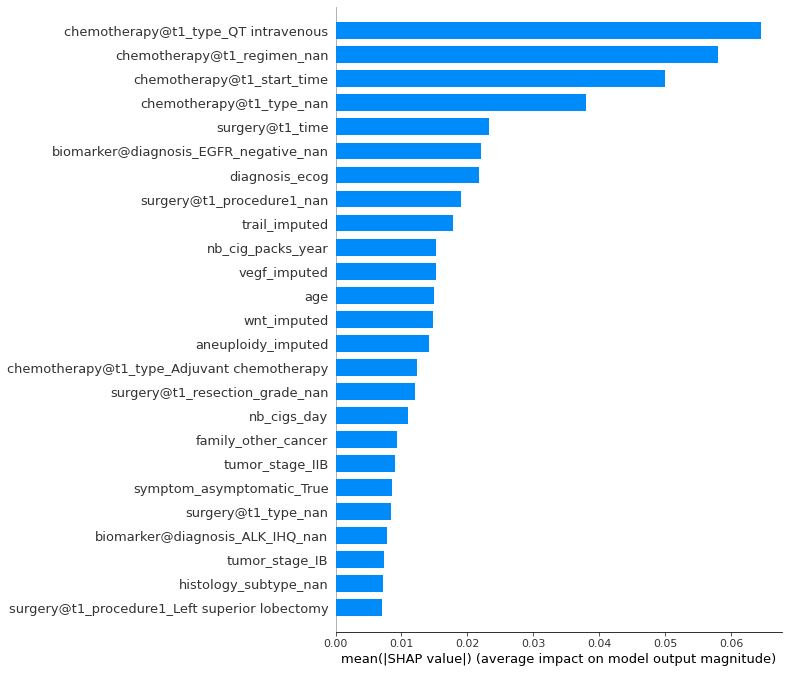

In [13]:
f = plt.figure()
shap.summary_plot(shap_values, features=X, feature_names=new_df.columns.values, plot_type='bar',max_display = 25)
f.savefig("bar_plot_rf.pdf", bbox_inches='tight')

In [14]:
shap_values.values.shape

(1348, 219)

In [15]:
model = GradientBoostingClassifier()
model.fit(X, Y)
explainer = shap.Explainer(model.predict, X,feature_names=new_df.columns.values)
# explainer = shap.TreeExplainer(model)
shap_values = explainer(X)


Permutation explainer: 1349it [01:36, 12.49it/s]                                                                                                                                                            


This is the plot of the patient 1


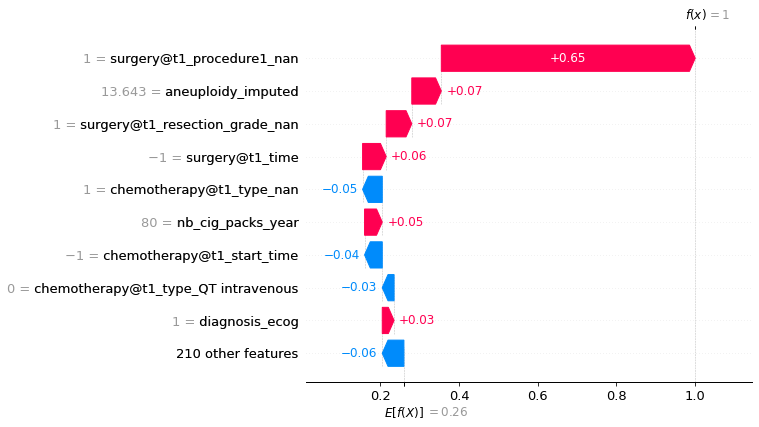

In [16]:
ix = 3
print("This is the plot of the patient",Y[ix])
shap.plots.waterfall(shap_values[ix])

This is the plot of patient 0


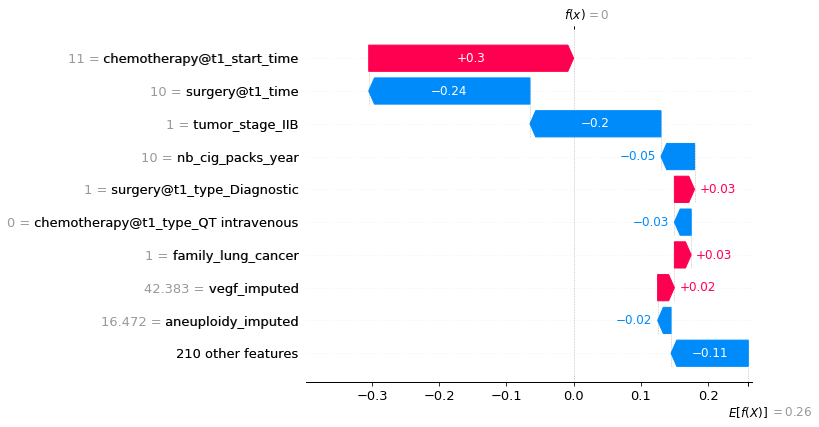

In [17]:
ix =21
print("This is the plot of patient",Y[ix])
# shap.plots.waterfall(shap_values[ix])
x = shap.plots.waterfall(shap_values[ix])


In [18]:
# shap.plots.waterfall(shap[2])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


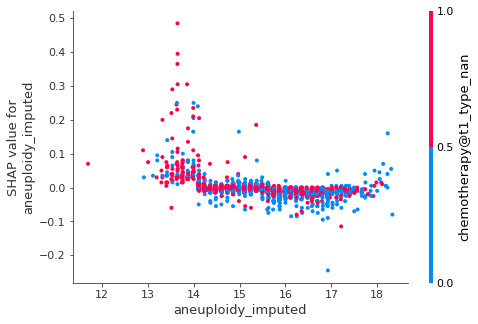

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


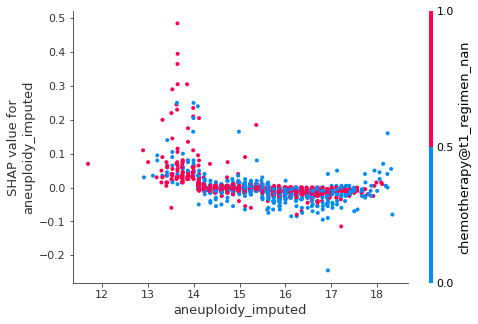

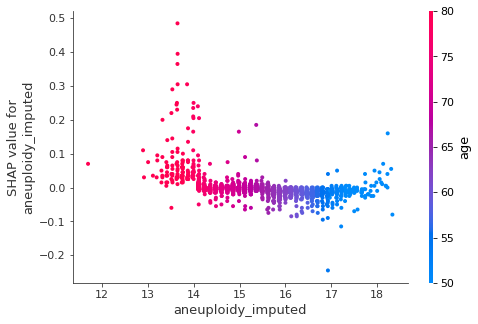

In [19]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("aneuploidy_imputed", shap_values.values, X,feature_names = new_df.columns.values)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("aneuploidy_imputed", shap_values.values, X, interaction_index=inds[i],feature_names = new_df.columns.values)


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


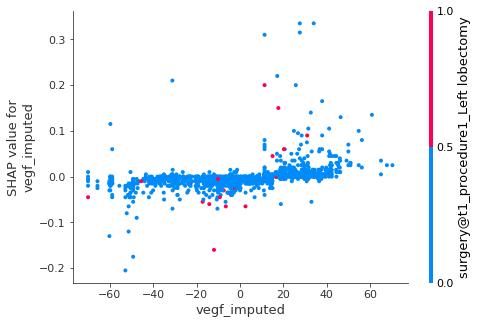

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


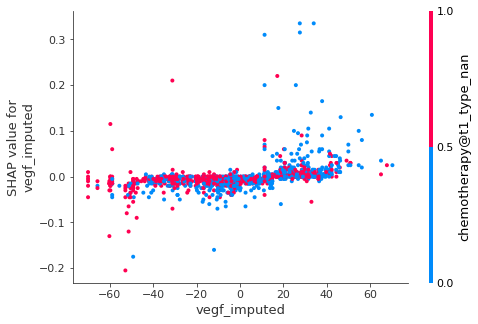

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


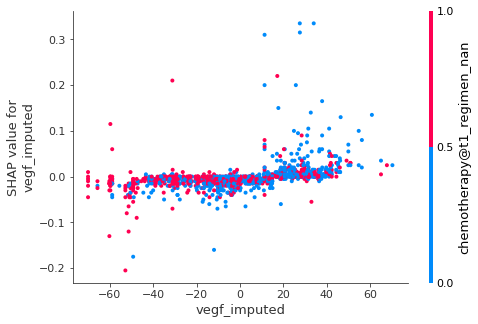

In [20]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("vegf_imputed", shap_values.values, X,feature_names = new_df.columns.values)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("vegf_imputed", shap_values.values, X, interaction_index=inds[i],feature_names = new_df.columns.values)


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


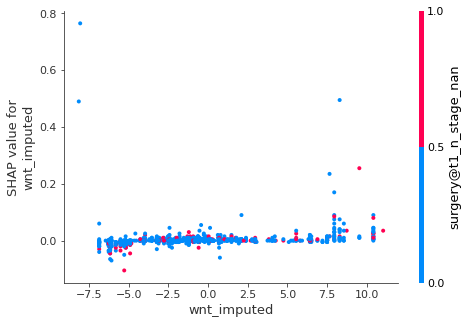

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


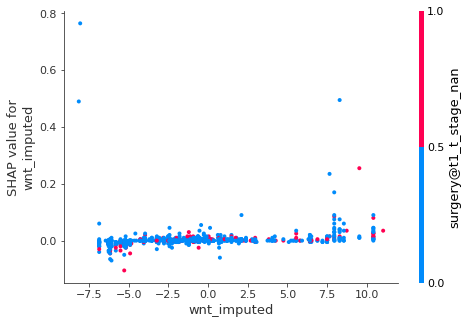

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


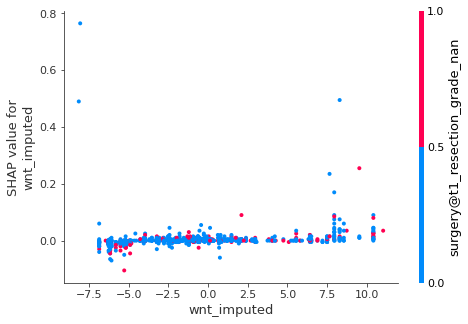

In [21]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("wnt_imputed", shap_values.values, X,feature_names = new_df.columns.values)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("wnt_imputed", shap_values.values, X, interaction_index=inds[i],feature_names = new_df.columns.values)


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


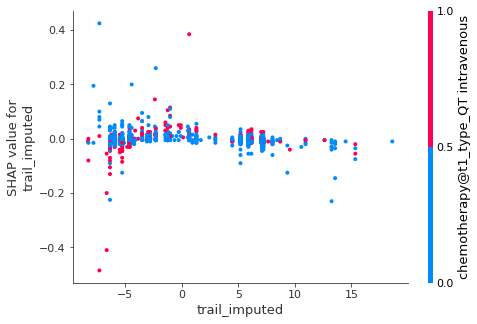

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


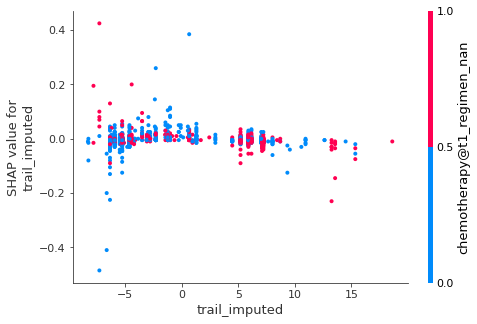

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


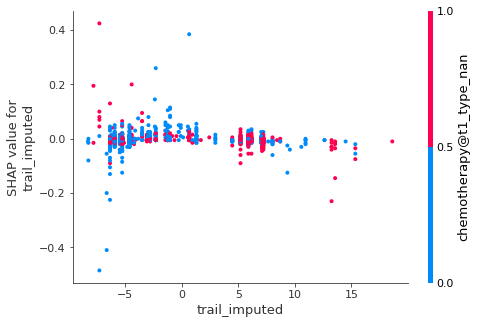

In [22]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("trail_imputed", shap_values.values, X,feature_names = new_df.columns.values)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("trail_imputed", shap_values.values, X, interaction_index=inds[i],feature_names = new_df.columns.values)


In [41]:
def calculate_metrics(y_predicted, y_predicted_prob,y_true):
    accuracy = accuracy_score(y_true, y_predicted)
    precision = precision_score(y_true, y_predicted)
    recall = recall_score(y_true, y_predicted)
    f_score =  f1_score(y_true, y_predicted)
    roc_score = roc_auc_score(y_true,y_predicted_prob)
    prec, rec, _ = precision_recall_curve(y_true,y_predicted_prob)
    auc_score = auc(rec, prec)
    return accuracy, precision,recall,f_score,roc_score,auc_score
    

    


In [43]:
def svm_class(X_train,y_train,X_test, y_test):
    score = 'roc_auc'
#     model = SVC(kernel = "linear",probability=True,random_state=123)
    model = LinearSVC(random_state = 123)
    param = [{
             'C':np.logspace(-3, 3, 5)
             }
            ]
    
    
    clf = GridSearchCV(model, param, cv=2, scoring = score, n_jobs=-1)
    clf = CalibratedClassifierCV(clf) 
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score


def logistic_regression(X_train,y_train,X_test, y_test):
    score = 'roc_auc'
    model = LogisticRegression(n_jobs=-1, random_state=123)

    param = [{'penalty':["l1","l2"],
             'C':np.logspace(-4, 4, 5)
             }
            ]
    
    
    clf = GridSearchCV(model, param, cv=2, scoring = score, n_jobs=-1)
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score

def random_forest(X_train,y_train,X_test, y_test):
    score = 'roc_auc'
    model = RandomForestClassifier(n_jobs=-1, random_state=123)
    
    param =[{
                       'max_depth': range(3,10),
                       'n_estimators': (10, 50, 100, 200)
            }
           ]
 
    clf = GridSearchCV(model, param, cv=2, scoring = score,n_jobs=-1)
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score


def gbm(X_train,y_train,X_test, y_test):
    score = 'roc_auc'
    model = GradientBoostingClassifier(n_jobs=-1, random_state=123)
    
    param =[{
                       'max_depth': range(3,10),
                       'n_estimators': (10, 50, 100, 200)
            }
           ]
 
    clf = GridSearchCV(model, param, cv=2, scoring = score,n_jobs=-1)
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score

def gbm(X_train,y_train,X_test, y_test):
    score = 'roc_auc'
    model = GradientBoostingClassifier(random_state=123)
    
  
    
    param =[{
                       'max_depth': range(3,10),
                       'n_estimators': (10, 50, 100, 200),
                       'min_samples_split': np.linspace(0.1, 0.5, 12),
                       'max_features':["log2","sqrt"]
            }
           ]
 
    clf = GridSearchCV(model, param, cv=2, scoring = score,n_jobs=-1)
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score

def neural_nets(X_train,y_train,X_test, y_test):
    score = 'roc_auc'
    model = MLPClassifier(random_state=123)
      
    param =[{
                       'hidden_layer_sizes': range(2,10),
                       'activation': ["relu"],
                       'solver': ["adam"]
                      
            }
           ]
 
    clf = GridSearchCV(model, param, cv=2, scoring = score,n_jobs=-1)
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score

In [44]:
if __name__ == "__main__":
    FOLDS = 5
#     skf = KFold(n_splits=FOLDS)
    kf = StratifiedKFold(n_splits=FOLDS)
#     kf = KFold(n_splits=FOLDS,random_state=7,shuffle=True)
#     models = ["svc","logistic_regression","random_forest","gbm","neural_networks"]
    models = ["svc","logistic_regression","random_forest","gbm","neural_networks"]
    eval_metrics = {}
    for mod in models:
        cnt = 0
        acc = np.zeros(FOLDS)
        prec = np.zeros(FOLDS)
        rec = np.zeros(FOLDS)
        f_score = np.zeros(FOLDS)
        roc_score = np.zeros(FOLDS)
        auc_pr = np.zeros(FOLDS)
#         for train_index, test_index in skf.split(X,Y):
        for train_index, test_index in kf.split(X,Y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
    
            if mod =="logistic_regression":
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = logistic_regression(X_train, y_train,X_test, y_test)
                
            elif mod =="random_forest":
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = random_forest(X_train, y_train,X_test, y_test)
                
            
            elif mod =="svc":
                
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = svm_class(X_train, y_train,X_test, y_test)
                
            
            elif mod =="neural_networks":
                
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = neural_nets(X_train, y_train,X_test, y_test)
            
            else:
                
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = gbm(X_train, y_train,X_test, y_test)
    
            cnt+=1
        
        print ("Results for:",mod)
        print ("Accuracy:",np.around(acc.mean(),decimals=2),u"\u00B1",np.around(acc.std(),decimals=2))
        print ("Precision:",np.around(prec.mean(),decimals=2),u"\u00B1",np.around(prec.std(),decimals=2))
        print ("Recall:",np.around(rec.mean(),decimals=2),u"\u00B1",np.around(rec.std(),decimals=2))
        print ("F1_score:", np.around(f_score.mean(),decimals=2),u"\u00B1",np.around(f_score.std(),decimals=2))
        print ("ROC_score:", np.around(roc_score.mean(),decimals=2),u"\u00B1",np.around(roc_score.std(),decimals=2))
        print ("PR_score",np.around(auc_pr.mean(),decimals=2),u"\u00B1",np.around(auc_pr.std(),decimals=2))
        eval_metrics[mod]= [acc.mean(),prec.mean(),rec.mean(),f_score.mean(),roc_score.mean(),auc_pr.mean()]
        

Results for: svc
Accuracy: 0.75 ± 0.02
Precision: 0.8 ± 0.06
Recall: 0.43 ± 0.06
F1_score: 0.56 ± 0.06
ROC_score: 0.77 ± 0.03
PR_score 0.71 ± 0.04



10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver lbfgs supports only 'l2' or 'none' pe

Results for: logistic_regression
Accuracy: 0.74 ± 0.03
Precision: 0.7 ± 0.07
Recall: 0.49 ± 0.06
F1_score: 0.57 ± 0.05
ROC_score: 0.76 ± 0.04
PR_score 0.69 ± 0.05
Results for: random_forest
Accuracy: 0.76 ± 0.03
Precision: 0.78 ± 0.08
Recall: 0.49 ± 0.08
F1_score: 0.6 ± 0.07
ROC_score: 0.8 ± 0.04
PR_score 0.75 ± 0.06
Results for: gbm
Accuracy: 0.75 ± 0.03
Precision: 0.74 ± 0.1
Recall: 0.49 ± 0.04
F1_score: 0.59 ± 0.04
ROC_score: 0.78 ± 0.03
PR_score 0.72 ± 0.05


/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py3

Results for: neural_networks
Accuracy: 0.73 ± 0.03
Precision: 0.67 ± 0.04
Recall: 0.54 ± 0.08
F1_score: 0.59 ± 0.06
ROC_score: 0.77 ± 0.05
PR_score 0.7 ± 0.07


In [45]:
# eval_metrics

In [46]:
eval_metrics
df = pd.DataFrame(data=eval_metrics)
df.index = ['Accuracy', 'Precision', 'Recall','F1','ROC','AUC_PR']
df

,svc,logistic_regression,random_forest,gbm,neural_networks
Accuracy,0.752948,0.737362,0.764822,0.748492,0.733642
Precision,0.800494,0.703656,0.782590,0.740585,0.666649
Recall,0.429705,0.486724,0.492620,0.492909,0.535415
F1,0.557018,0.573621,0.601200,0.588996,0.591247
ROC,0.772112,0.760714,0.796392,0.778292,0.770268
AUC_PR,0.711797,0.691070,0.745440,0.717814,0.699904
